In [ ]:
from __future__ import unicode_literals, print_function
import plac
import random
from pathlib import Path
import thinc.extra.datasets
import pandas as pd
import spacy
from spacy.util import minibatch, compounding
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import numpy as np
from numpy import array, unique, array_equal
max_fatures = 1500
import matplotlib.pyplot as plt
import seaborn as sns


def load_data():
    print("Loading Data...")
    PrimaryEmotion = pd.read_csv('emotion.xls.csv')
    print("Data Loaded")
    return (PrimaryEmotion['sentence'], array(PrimaryEmotion['emotion']))


#Below the data is sorted into nine emotion groups. Eight of the groups are the outter layer of the wheel, or the combinations of 
#two emotion groups. The ninth group is "Ambiguous" and "Neutral" put together.
def sort_to_9_emotions(sentence_list, emotion_list):
    sorted_list = []
    sorted_emo = []
    for (data, emo) in zip(sentence_list, emotion_list):
        if (emo == 'Contempt' or emo == 'Anger' or emo == 'Disgust'):
            sorted_list.append(data)
            sorted_emo.append("Contempt")
        if (emo == 'Aggression' or emo == 'Anticipation' or emo == 'Anger'):
            sorted_list.append(data)
            sorted_emo.append("Aggression")
        if (emo == 'Optimism' or emo == 'Anticipation' or emo == 'Joy'):
            sorted_list.append(data)
            sorted_emo.append("Optimism")
        if (emo == 'Love' or emo == 'Joy' or emo == 'Trust'):
            sorted_list.append(data)
            sorted_emo.append("Love")
        if (emo == 'Submission' or emo == 'Trust' or emo == 'Fear'):
            sorted_list.append(data)
            sorted_emo.append("Submission")
        if (emo == 'Awe' or emo == 'Fear' or emo == 'Surprise'):
            sorted_list.append(data)
            sorted_emo.append("Awe")
        if (emo == 'Disapproval' or emo == 'Surprise' or emo == 'Saddness'):
            sorted_list.append(data)
            sorted_emo.append("Disapproval")
        #if (emo == 'Remorse' or emo == 'Saddness' or emo == 'Disgust'):
         #   sorted_list.append(data)
          #  sorted_emo.append("Remorse")
        if (emo == 'Neutral' or emo == 'Ambiguous'):
            sorted_list.append(data)
            sorted_emo.append("Neutral")
    return (sorted_list, sorted_emo)



def tokenize(sentences):
    print("Tokenizing...")
    tokenizer = Tokenizer(num_words=max_fatures, split=' ')
    tokenizer.fit_on_texts(sentences)
    X = tokenizer.texts_to_sequences(sentences)
    X = pad_sequences(X)
    print("Tokenization Completed")
    return X



def train(tokened_sentences, emotion_list, weigh_even=False):
    print("Training...")
    embed_dim = 128
    lstm_out = 196
    test_percent=.2

    model = Sequential()
    model.add(Embedding(max_fatures, embed_dim,input_length = tokened_sentences.shape[1]))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))
    
    # len(set(emotion_list)) is a hacky way of geting the number of unique elements
    # in a regualar python list (non-numpy)
    model.add(Dense(unique(emotion_list).size,activation='softplus'))

    
    model.compile(loss = 'categorical_crossentropy', optimizer='Adam',metrics = ['accuracy'])
    #print(model.summary())
    
    Y = pd.get_dummies(emotion_list).values
    X_train, X_test, Y_train, Y_test = train_test_split(tokened_sentences,Y, test_size = test_percent, random_state = 55)

    

    batch_size = 16
    if (weigh_even):
        y_integers = np.argmax(Y_train, axis=1)
        class_weights = class_weight.compute_sample_weight('balanced', unique(emotion_list), y_integers)
    
    model.fit(X_train, Y_train, epochs = 150, batch_size=batch_size, verbose = 1)
    print("Training Completed")
    print("Testing Against Control... (% of the data) ", test_percent)
    score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
    print("Score   :", score)
    print("Accuracy:", acc)
    return (model, X_test)

### When Splitting data (train_test_split), we don't retain where in the 
### origional set the data is located, thus it takes
### a little trickery to see the results while while only testing against untrained data
### top_predictions variable changes how many predictions given
def test(model, X_test, tokenized_data, sentence_list, emotion_list, top_predictions=3):
    predictions = model.predict(tokenized_data, batch_size=32)
    error = 0
    for i in range(len(predictions)):
     
        #  "If the current tokenized data array is in X_test (untrained tokenized arrays)
        
        if(any(array_equal(tokenized_data[i], x) for x in X_test)):
            print("\n\n")

            
            pos = list(predictions[i]).index(max(predictions[i]))
            if (unique(emotion_list)[pos] != emotion_list[i]):
                error += 1
            temp = predictions[i]
            
            print(sentence_list[i])

            for j in range(top_predictions):
                pos = list(temp).index(max(temp))
                print("\n # {%s} Predicted emotion : ",j+1, unique(emotion_list)[pos])
                temp[pos] = 0
            print("Actual emotion   : ", emotion_list[i])
    
def count_errors(model, tokenized_data, sentence_list, emotion_list):
    dims =  len(unique(emotion_list))
    mistake_list = np.zeros((dims,dims), dtype=np.int)
    predictions = model.predict(tokenized_data, batch_size=32)
    for i in range(len(predictions)):
            pos = list(predictions[i]).index(max(predictions[i]))
            mistake_list[list(unique(emotion_list)).index(emotion_list[i])][pos] += 1
    for i in range(len(mistake_list)):
        for j in range(len(mistake_list)):
            mistake_list[i][j] = mistake_list[i][j] * 100 / list(emotion_list).count(unique(emotion_list)[i]) 
    print(mistake_list)
    return mistake_list


def graph_errors(mistake_list, emotion_list):
    dim = len(mistake_list[0])
    
    false =  np.zeros((dim,3), dtype=np.int)
    
    #true positives
    for i in range(dim):
              false[i][0] = mistake_list[i][i]
    #false positives
    for i in range(dim):
        sum = 0
        for j in range(dim):
            if (i != j):
                sum += mistake_list[i][j]
        false[i][1] = sum
        
            #false Negatives
    for i in range(dim):
        sum = 0
        for j in range(dim):
            if (i != j):
                sum += mistake_list[j][i]
        false[i][2] = sum
    df = pd.DataFrame(false)
    df.columns = ["Correct", "False Positives", "False Negatives"]
    df.insert(0, "Emotion", np.unique(emotion_list))
    (_, counts) = np.unique(emotion_list,return_counts=True)
    for i in range(counts.size):
        counts[i] = counts[i] / 10
    df.insert(1,"Amount of Data / 10",counts)
    print(df)
    df.plot.bar(x='Emotion',figsize=(6,8))
    #plot = sns.barplot(x="Emotion",y=Correct, data=df)




#################################
#############MAIN################
#################################
#   jupyter notebook is weird   #




(sentence_list, emotion_list) = load_data()


### Comment the Below line for all 18 emotions. This sorts into "positive" and "negative"
sentence_list, emotion_list = sort_to_9_emotions(sentence_list, emotion_list)

tokenized_data = tokenize(sentence_list)

(model, X_test) = train(tokenized_data, emotion_list)

#test(model, X_test, tokenized_data, sentence_list, emotion_list)

mistake_list = count_errors(model, tokenized_data, sentence_list, emotion_list)

graph_errors(mistake_list, emotion_list)



Loading Data...
Data Loaded
Tokenizing...
Tokenization Completed
Training...
Epoch 1/150
2523/2523 [==============================] - 20s 8ms/step - loss: 2.0277 - acc: 0.2117
Epoch 2/150
2523/2523 [==============================] - 18s 7ms/step - loss: 1.9701 - acc: 0.2315
Epoch 3/150
2523/2523 [==============================] - 19s 7ms/step - loss: 1.8237 - acc: 0.2957
Epoch 4/150
2523/2523 [==============================] - 19s 7ms/step - loss: 1.6515 - acc: 0.3714
Epoch 5/150
2523/2523 [==============================] - 19s 7ms/step - loss: 1.5111 - acc: 0.4142
Epoch 6/150
2523/2523 [==============================] - 19s 7ms/step - loss: 1.3981 - acc: 0.4681
Epoch 7/150
2523/2523 [==============================] - 19s 7ms/step - loss: 1.3047 - acc: 0.4744
Epoch 8/150
2523/2523 [==============================] - 18s 7ms/step - loss: 1.2324 - acc: 0.5085
Epoch 9/150
2523/2523 [==============================] - 18s 7ms/step - loss: 1.1693 - acc: 0.5129
Epoch 10/150
2523/2523 [========

       Emotion  Amount of Data / 10  Correct  False Positives  False Negatives
0   Aggression                   38       37               60               29
1          Awe                   25       25               70               13
2     Contempt                   29       75               21               39
3  Disapproval                   42       73               24               36
4         Love                   28       43               52               18
5      Neutral                   63       83               12               20
6     Optimism                   63       71               25               81
7   Submission                   23       74               22               50


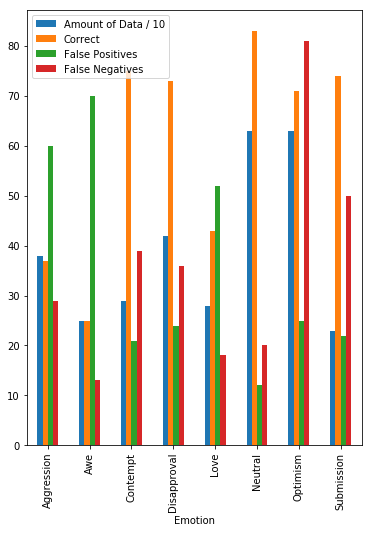

In [2]:
graph_errors(mistake_list, emotion_list)
